In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist

import gymnasium as gym


In [2]:
from algorithms.reinforce import ReinforceAgent
from algorithms.dqn import DQNAgent
from networks.policy import DiscretePolicy, ContinuousPolicy
from networks.value_networks import Qnet
from utils.eval_utils import *

# REINFORCE

Evaluate ReinforceAgent on Classic Control Environments

### Acrobot

In [3]:
ENV_NAME = 'Acrobot-v1'
env = gym.make(ENV_NAME)

policy = DiscretePolicy(
    env.observation_space.shape[0], 
    env.action_space.n, 
    2*(env.action_space.n+env.observation_space.shape[0])
)

reinforce_agent = ReinforceAgent(policy, policy_lr=1.0e-3, optimiser=optim.SGD)

reinforce_agent.train(
    env_name = ENV_NAME, 
    num_envs=4,
    num_iters=125, 
    steps_per_iter=501, 
    eval_freq=25
)

evaluating at 0
evaluating at 50100
evaluating at 100200
evaluating at 150300
evaluating at 200400


In [4]:
import pandas as pd
df = pd.DataFrame(reinforce_agent.batch_results).T

,log_probs,rewards,returns,policy_gradient,policy_entropy,episode_len
0,-1.0743904,-500.0,-3.245866,-34.06000443464482,-0.35907954,499.0
1,-1.0558335,-495.0,-15.890409,-65.95060573321648,-0.35522637,494.25
2,-1.0507182,-500.0,-3.245866,-29.791455473405733,-0.3518781,499.0
3,-1.0324686,-500.0,-3.245866,-19.63191920552653,-0.3501163,499.0
4,-1.0397453,-500.0,-3.245866,-16.650361690935434,-0.34696382,499.0
...,...,...,...,...,...,...
120,-0.43694094,-109.941176,-5.828706,-291.49045253655015,-0.13889916,110.705882
121,-0.45377374,-89.285714,-4.723629,-360.05268220666153,-0.14035676,90.095238
122,-0.41526973,-96.105263,-7.09724,-338.86877980207976,-0.12751265,96.894737
123,-0.39659673,-103.277778,-6.120692,-287.213910382429,-0.12183867,104.055556


: 

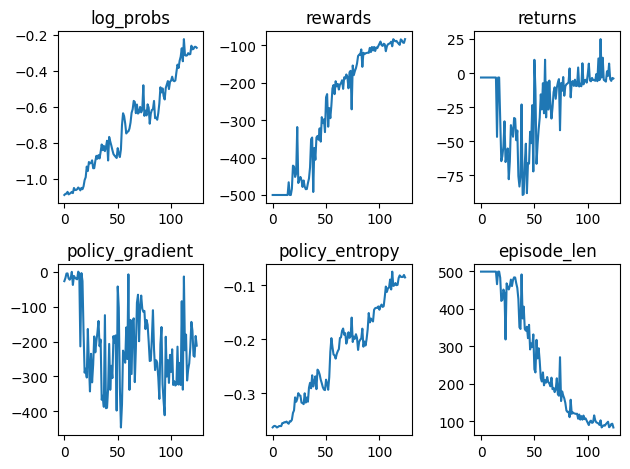

In [5]:
plot_training_results(reinforce_agent.batch_results)

In [11]:
ENV_NAME = 'Acrobot-v1'
env = gym.make(ENV_NAME)

q_net = Qnet(
    env.observation_space.shape[0], 
    env.action_space.n, 
    2*(env.action_space.n+env.observation_space.shape[0]),
    2
)

dqn_agent = DQNAgent(q_net, 
        lr=1.0e-4, 
        optimiser=optim.AdamW,
        buffer_size=10000,
        mini_batch_size=128,
        epsilon=.9,
        discount_rate=.99)

dqn_agent.train(ENV_NAME, num_envs=4, num_iters=125, steps_per_iter=501, eval_freq=25)

evaluating at 0...
-500.0
evaluating at 50100...
-500.0
evaluating at 100200...
-449.7
evaluating at 150300...
-500.0
evaluating at 200400...
-500.0


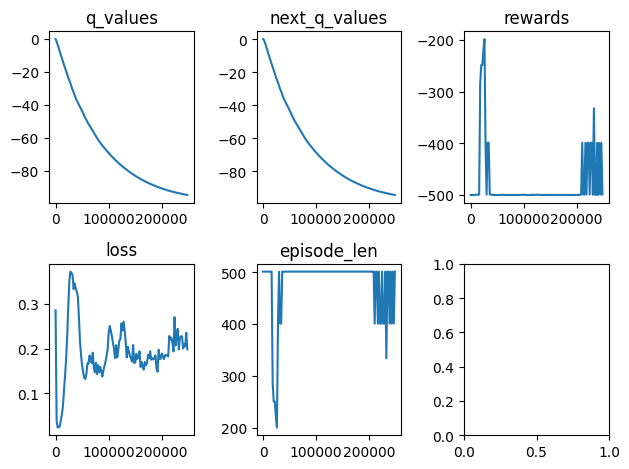

In [12]:
plot_training_results(dqn_agent.batch_results)

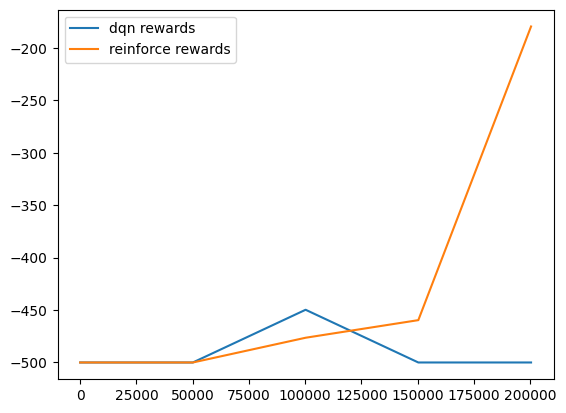

In [13]:
plt.plot(
    dqn_agent.eval_results.keys(),
    dqn_agent.eval_results.values(),
    label='dqn rewards'
)

plt.plot(
    reinforce_agent.eval_results.keys(),
    reinforce_agent.eval_results.values(),
    label='reinforce rewards'
)

plt.legend()
plt.show();

### CartPole

In [5]:
ENV_NAME = 'CartPole-v1'
env = gym.make(ENV_NAME)

policy = DiscretePolicy(
    env.observation_space.shape[0], 
    env.action_space.n, 
    2*(env.action_space.n+env.observation_space.shape[0])
)
agent = ReinforceAgent(policy, policy_lr=.03, optimiser=optim.Adam)

agent.train(env, num_iters=50, batch_size=10)

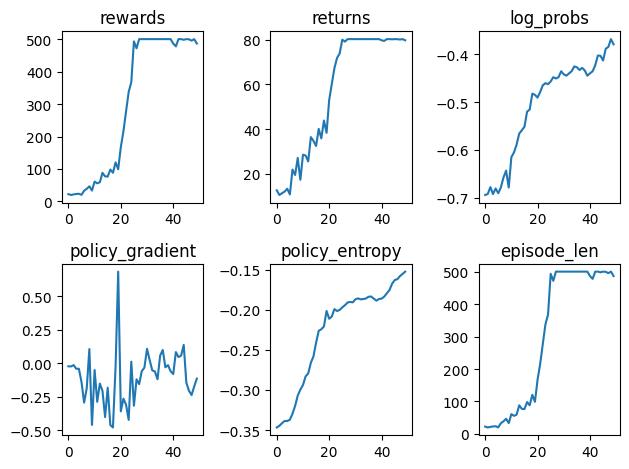

In [6]:
plot_training_results(agent.batch_results)

In [32]:
rewards = eval_agent(agent, env, 10)
print(rewards)

{0: 444.0, 1: 156.0, 2: 356.0, 3: 256.0, 4: 364.0, 5: 500.0, 6: 423.0, 7: 500.0, 8: 363.0, 9: 423.0}


### Mountain Car

In [7]:
ENV_NAME = 'MountainCar-v0'
env = gym.make(ENV_NAME)

policy = DiscretePolicy(
    env.observation_space.shape[0], 
    env.action_space.n, 
    1*(env.action_space.n+env.observation_space.shape[0])
)
agent = ReinforceAgent(policy, policy_lr=.03, optimiser=optim.Adam)

agent.train(env, num_iters=50, batch_size=10)

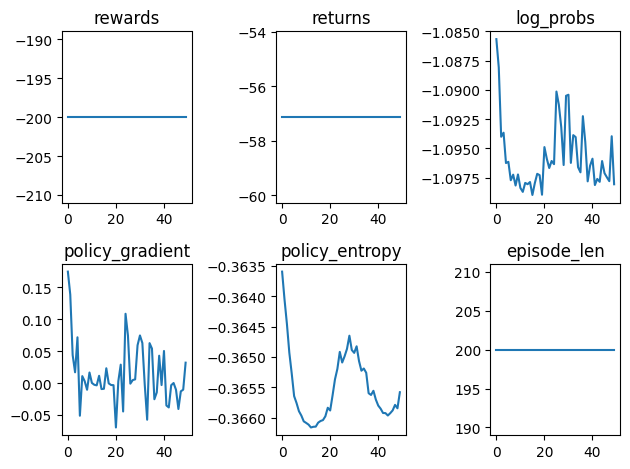

In [8]:
plot_training_results(agent.batch_results)

In [35]:
rewards = eval_agent(agent, env, 10)
print(rewards)

{0: -200.0, 1: -200.0, 2: -200.0, 3: -200.0, 4: -200.0, 5: -200.0, 6: -200.0, 7: -200.0, 8: -200.0, 9: -200.0}


### Mountain Car Continuous

In [9]:
ENV_NAME = 'MountainCarContinuous-v0'
env = gym.make(ENV_NAME)

policy = ContinuousPolicy(
    env.observation_space.shape[0], 
    env.action_space.shape[0], 
    2*(env.action_space.shape[0]+env.observation_space.shape[0])
)
agent = ReinforceAgent(policy, policy_lr=.03, optimiser=optim.Adam)

agent.train(env, num_iters=50, batch_size=10)

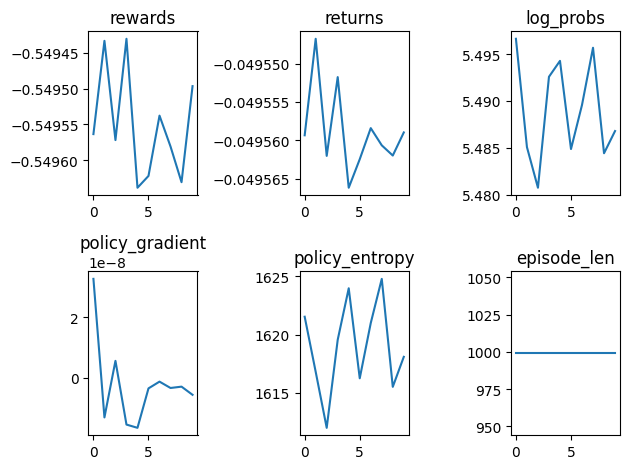

In [14]:
plot_training_results(agent.batch_results)

### Pendulum

In [18]:
ENV_NAME = 'Pendulum-v1'
env = gym.make(ENV_NAME)

policy = ContinuousPolicy(
    env.observation_space.shape[0], 
    env.action_space.shape[0], 
    2*(env.action_space.shape[0]+env.observation_space.shape[0])
)

agent = ReinforceAgent(policy, policy_lr=.03, optimiser=optim.Adam)
agent.train(env, num_iters=20, batch_size=10)

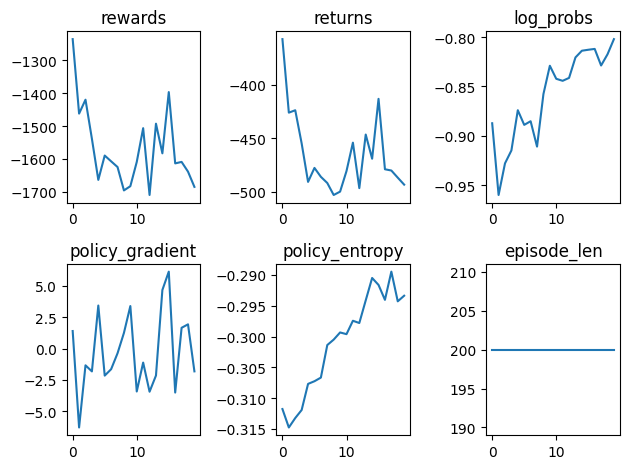

In [19]:
plot_training_results(agent.batch_results)

In [17]:
import gymnasium as gym
import torch
ENV_NAME = 'CartPole-v1'
env = gym.make_vec(ENV_NAME, num_envs=2)

In [20]:
obs, info = env.reset()
action = env.action_space.sample()
print(obs)
print(action)
next_obs, reward, terminated, truncated, info = env.step(action)
print(torch.tensor(next_obs))
print(torch.tensor(reward))
print(torch.tensor(terminated))
print(torch.tensor(truncated))
print(info)

[[-0.04961836 -0.00863058  0.04882018 -0.02344691]
 [ 0.0309924   0.00606556  0.03108878 -0.03862969]]
[1 0]
tensor([[-0.0498,  0.1858,  0.0484, -0.3003],
        [ 0.0311, -0.1895,  0.0303,  0.2637]])
tensor([1., 1.])
tensor([False, False])
tensor([False, False])
{}


In [27]:
terminated
truncated

array([False, False])

In [31]:
env.action_space.sample()

array([0, 0, 0])

In [33]:
import gymnasium as gym
import torch

NUM_STEPS = 100
NUM_ENVS = 5
ENV_NAME = 'CartPole-v1'
env = gym.make_vec(ENV_NAME, num_envs=NUM_ENVS)

masks = torch.zeros(NUM_STEPS, NUM_ENVS)

obs, info = env.reset()
for i in range(NUM_STEPS):

    actions = env.action_space.sample()
    next_obs, reward, terminated, truncated, info = env.step(actions)
    if any(terminated):
        print(i, 'terminated!', sum(terminated), sum(truncated))
    

    masks[i] = torch.tensor([not term for term in terminated])
    

print(masks)

9 terminated! 1 0
17 terminated! 1 0
18 terminated! 1 0
21 terminated! 1 0
23 terminated! 1 0
29 terminated! 1 0
33 terminated! 1 0
35 terminated! 2 0
48 terminated! 1 0
51 terminated! 1 0
52 terminated! 1 0
62 terminated! 1 0
66 terminated! 1 0
77 terminated! 2 0
80 terminated! 1 0
81 terminated! 1 0
87 terminated! 1 0
93 terminated! 1 0
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0.],
        [1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1.],

In [41]:
mask = torch.tensor(
    [
        [1,1,1,0,1,1,1,0],
        [1,1,1,1,1,1,1,0],
        [1,0,1,1,1,1,1,1]
    ]
)

mask[:,(mask == 0).nonzero()]

# torch.ones_like(mask)

tensor([[[1, 0],
         [1, 0],
         [1, 0],
         [1, 1]],

        [[1, 1],
         [1, 0],
         [1, 0],
         [1, 1]],

        [[1, 1],
         [1, 1],
         [0, 1],
         [1, 0]]])

In [54]:
(mask==0).nonzero(as_tuple=True)[0].max()

tensor(2)

In [72]:
import torch

# Your initial tensor
mask = torch.tensor(
    [
        [1, 1, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1]
    ]
)

# Function to set all 1s after the last 0 to 0
def reset_after_last_zero(mask):
    result = mask.clone()
    for row in range(result.size(0)):
        if (result[row].size()[0]==result[row].sum().item()):
            result[row, :] = -1
        else:
            last_zero_idx = (
                (result[row] == 0).nonzero(as_tuple=True)[0].max().item() 
                if (result[row] == 0).any() else -1
            )

            if last_zero_idx != -1:
                result[row, last_zero_idx + 1:] = -1

    return result

# Apply the function
modified_mask = reset_after_last_zero(mask)

print("Original mask:")
print(mask)
print("Modified mask:")
print(modified_mask)
print(mask.flatten()[(modified_mask.flatten()!=-1)])


Original mask:
tensor([[1, 1, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1]])
Modified mask:
tensor([[ 1,  1,  1,  0,  1,  1,  1,  0],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [ 1,  0, -1, -1, -1, -1, -1, -1]])
tensor([1, 1, 1, 0, 1, 1, 1, 0, 1, 0])


In [74]:
dones = torch.tensor(
    [
        [0,0,0,1,0,0,1],
        [0,1,0,1,0,0,0],
        [0,1,0,0,0,0,0]
    ]
)

dones.flatten().sum()

tensor(5)